In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from calendar import isleap
from scipy.interpolate import griddata
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy import config
import cartopy.mpl.ticker as cticker
import cartopy.io.shapereader as shpreader
import nctoolkit as nct

Please install CDO version 1.9.4 or above: https://code.mpimet.mpg.de/projects/cdo/ or https://anaconda.org/conda-forge/cdo


In [3]:
# function to find lines to skip in weather files
def find_line(path, target):
    with open(path) as fh:
        count = 1
        for line in fh:
#             print(line.strip()[0:5])
            if line.strip()[0:5] == target:
                return count
            count += 1
    return 0

In [7]:
# 47 station coordinates
coords = pd.read_csv("coords1.csv")
coords = coords.sort_values("stn")
stn = coords["stn"]
lon = coords["lon"]
lat = coords["lat"]
# lat
coords

,stn,lon,lat
2,ABEO,3.33,7.20
3,ABUJ,7.20,9.00
4,ADEK,5.20,7.60
5,AKUR,5.30,7.20
6,ASAB,6.23,6.82
7,AWKA,7.07,6.20
8,BAUC,9.82,10.28
9,BENI,5.60,6.33
10,BIDA,5.60,6.33
11,CALA,8.35,4.97


In [24]:
all_stn_wth_files_tmax = pd.DataFrame(columns=["DATE"])

for station in stn:
    print(station)
    all_wth_files_tmax = []
    # read each station data from weather files
    weather_files = glob.glob("Weather/Weather/" + station + "*.WTH")
    for file in weather_files:
#         print(weather_files)
        to_skip = find_line(path=file, target="@DATE")
        wth_file = pd.read_fwf(file, skiprows = to_skip, 
                               usecols = [0,2,3,4],
                               names = ["DATE", "TMAX", "TMIN", "RAIN"],
                               dtype={"DATE":str})
        wth_file.DATE[0][0:2]
        if float(wth_file.DATE[0][0:2]) < 50:
            year = "20" + wth_file.DATE[0][0:2]
        else:
            year = "19" + wth_file.DATE[0][0:2]
#             print(year)
        wth_file["YEAR"] = year
        wth_file["DOY"] = list(range(1,len(wth_file)+1))
        
        if isleap(float(year)):
            days_in_month = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
        else:
            days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
            
        print(file, year, to_skip, wth_file.DATE[0][0:2], len(wth_file.columns), days_in_month)
            
        wth_file["DAYS"] = np.concatenate([list(range(1, i+1)) for i in days_in_month])
        wth_file["MONTHS"] = np.concatenate([[j]*i for i, j in zip(days_in_month, list(range(1,13)))])
        wth_file["DATE"] = wth_file["DAYS"].astype(str) + "/" + wth_file["MONTHS"].astype(str) + "/" + wth_file["YEAR"]
        wth_file_tmax = wth_file[["DATE","TMAX"]]
        wth_file_tmax.columns = ["DATE", station]
        all_wth_files_tmax.append(wth_file_tmax)
    all_wth_files_tmax = pd.concat(all_wth_files_tmax, axis = 0)
    
    all_stn_wth_files_tmax = all_stn_wth_files_tmax.merge(all_wth_files_tmax, left_on="DATE", right_on="DATE", how = "outer")




ABEO
Weather/Weather\ABEO0001.WTH 2000 7 00 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ABEO0101.WTH 2001 7 01 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ABEO0201.WTH 2002 7 02 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ABEO0301.WTH 2003 7 03 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ABEO0401.WTH 2004 7 04 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ABEO0501.WTH 2005 7 05 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ABEO0601.WTH 2006 7 06 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ABEO0701.WTH 2007 7 07 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ABEO0801.WTH 2008 7 08 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ABEO0901.WTH 2009 7 09 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ABEO1001.WTH 2010 7 10 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weath

Weather/Weather\ADEK1601.WTH 2016 6 16 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ADEK1701.WTH 2017 6 17 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ADEK1801.WTH 2018 6 18 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ADEK1901.WTH 2019 6 19 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ADEK2001.WTH 2020 6 20 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ADEK2101.WTH 2021 6 21 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ADEK8101.WTH 1981 6 81 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ADEK8201.WTH 1982 6 82 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ADEK8301.WTH 1983 6 83 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ADEK8401.WTH 1984 6 84 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ADEK8501.WTH 1985 6 85 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/We

Weather/Weather\ASAB8601.WTH 1986 6 86 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ASAB8701.WTH 1987 6 87 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ASAB8801.WTH 1988 6 88 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ASAB8901.WTH 1989 6 89 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ASAB9001.WTH 1990 6 90 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ASAB9101.WTH 1991 6 91 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ASAB9201.WTH 1992 6 92 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ASAB9301.WTH 1993 6 93 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ASAB9401.WTH 1994 6 94 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ASAB9501.WTH 1995 6 95 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ASAB9601.WTH 1996 6 96 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/We

Weather/Weather\BAUC8801.WTH 1988 6 88 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\BAUC8901.WTH 1989 6 89 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\BAUC9001.WTH 1990 6 90 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\BAUC9101.WTH 1991 6 91 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\BAUC9201.WTH 1992 6 92 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\BAUC9301.WTH 1993 6 93 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\BAUC9401.WTH 1994 6 94 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\BAUC9501.WTH 1995 6 95 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\BAUC9601.WTH 1996 6 96 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\BAUC9701.WTH 1997 6 97 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\BAUC9801.WTH 1998 6 98 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/We

Weather/Weather\BIDA8001.WTH 1980 6 80 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\BIDA8101.WTH 1981 6 81 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\BIDA8201.WTH 1982 6 82 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\BIDA8301.WTH 1983 6 83 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\BIDA8401.WTH 1984 6 84 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\BIDA8501.WTH 1985 6 85 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\BIDA8601.WTH 1986 6 86 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\BIDA8701.WTH 1987 6 87 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\BIDA8801.WTH 1988 6 88 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\BIDA8901.WTH 1989 6 89 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\BIDA9001.WTH 1990 6 90 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/We

Weather/Weather\DUTS7801.WTH 1978 6 78 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\DUTS7901.WTH 1979 6 79 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\DUTS8001.WTH 1980 6 80 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\DUTS8101.WTH 1981 6 81 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\DUTS8201.WTH 1982 6 82 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\DUTS8301.WTH 1983 6 83 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\DUTS8401.WTH 1984 6 84 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\DUTS8501.WTH 1985 6 85 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\DUTS8601.WTH 1986 6 86 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\DUTS8701.WTH 1987 6 87 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\DUTS8801.WTH 1988 6 88 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/We

Weather/Weather\ENUG7701.WTH 1977 6 77 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ENUG7801.WTH 1978 6 78 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ENUG7901.WTH 1979 6 79 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ENUG8001.WTH 1980 6 80 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ENUG8101.WTH 1981 6 81 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ENUG8201.WTH 1982 6 82 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ENUG8301.WTH 1983 6 83 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ENUG8401.WTH 1984 6 84 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ENUG8501.WTH 1985 6 85 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ENUG8601.WTH 1986 6 86 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ENUG8701.WTH 1987 6 87 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/We

Weather/Weather\GUSA1801.WTH 2018 6 18 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\GUSA1901.WTH 2019 6 19 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\GUSA2001.WTH 2020 6 20 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\GUSA2101.WTH 2021 6 21 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\GUSA7101.WTH 1971 6 71 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\GUSA7201.WTH 1972 6 72 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\GUSA7301.WTH 1973 6 73 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\GUSA7401.WTH 1974 6 74 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\GUSA7501.WTH 1975 6 75 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\GUSA7601.WTH 1976 6 76 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\GUSA7701.WTH 1977 6 77 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/We

Weather/Weather\IBI01501.WTH 2015 6 15 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\IBI01601.WTH 2016 6 16 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\IBI01701.WTH 2017 6 17 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\IBI01801.WTH 2018 6 18 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\IBI07101.WTH 1971 6 71 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\IBI07201.WTH 1972 6 72 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\IBI07301.WTH 1973 6 73 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\IBI07401.WTH 1974 6 74 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\IBI07501.WTH 1975 6 75 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\IBI07601.WTH 1976 6 76 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\IBI07701.WTH 1977 6 77 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/We

Weather/Weather\IKEJ1101.WTH 2011 6 11 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\IKEJ1201.WTH 2012 6 12 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\IKEJ1301.WTH 2013 6 13 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\IKEJ1401.WTH 2014 6 14 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\IKEJ1501.WTH 2015 6 15 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\IKEJ1601.WTH 2016 6 16 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\IKEJ1701.WTH 2017 6 17 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\IKEJ1801.WTH 2018 6 18 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\IKEJ1901.WTH 2019 6 19 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\IKEJ2001.WTH 2020 6 20 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\IKEJ2101.WTH 2021 6 21 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/We

Weather/Weather\ILOR0401.WTH 2004 6 04 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ILOR0501.WTH 2005 6 05 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ILOR0601.WTH 2006 6 06 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ILOR0701.WTH 2007 6 07 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ILOR0801.WTH 2008 6 08 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ILOR0901.WTH 2009 6 09 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ILOR1001.WTH 2010 6 10 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ILOR1101.WTH 2011 6 11 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ILOR1201.WTH 2012 6 12 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ILOR1301.WTH 2013 6 13 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ILOR1401.WTH 2014 6 14 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/We

Weather/Weather\JOS00801.WTH 2008 6 08 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\JOS00901.WTH 2009 6 09 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\JOS01001.WTH 2010 6 10 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\JOS01101.WTH 2011 6 11 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\JOS01201.WTH 2012 7 12 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\JOS01301.WTH 2013 8 13 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\JOS01401.WTH 2014 7 14 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\JOS01501.WTH 2015 6 15 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\JOS01601.WTH 2016 5 16 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\JOS01701.WTH 2017 6 17 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\JOS01801.WTH 2018 6 18 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/We

KANO
Weather/Weather\KANO0001.WTH 2000 6 00 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\KANO0101.WTH 2001 6 01 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\KANO0201.WTH 2002 6 02 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\KANO0301.WTH 2003 6 03 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\KANO0401.WTH 2004 6 04 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\KANO0501.WTH 2005 6 05 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\KANO0601.WTH 2006 6 06 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\KANO0701.WTH 2007 6 07 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\KANO0801.WTH 2008 6 08 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\KANO0901.WTH 2009 6 09 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\KANO1001.WTH 2010 6 10 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weath

Weather/Weather\KATS9401.WTH 1994 6 94 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\KATS9501.WTH 1995 6 95 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\KATS9601.WTH 1996 6 96 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\KATS9701.WTH 1997 6 97 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\KATS9801.WTH 1998 6 98 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\KATS9901.WTH 1999 6 99 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
LAFI
Weather/Weather\LAFI0001.WTH 2000 6 00 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\LAFI0101.WTH 2001 6 01 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\LAFI0201.WTH 2002 6 02 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\LAFI0301.WTH 2003 6 03 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\LAFI0401.WTH 2004 6 04 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weath

Weather/Weather\LOKO0001.WTH 2000 6 00 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\LOKO0101.WTH 2001 6 01 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\LOKO0201.WTH 2002 6 02 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\LOKO0301.WTH 2003 6 03 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\LOKO0401.WTH 2004 6 04 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\LOKO0501.WTH 2005 6 05 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\LOKO0601.WTH 2006 6 06 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\LOKO0701.WTH 2007 6 07 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\LOKO0801.WTH 2008 6 08 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\LOKO0901.WTH 2009 6 09 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\LOKO1001.WTH 2010 6 10 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/We

Weather/Weather\MAID9501.WTH 1995 6 95 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\MAID9601.WTH 1996 6 96 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\MAID9701.WTH 1997 6 97 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\MAID9801.WTH 1998 6 98 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\MAID9901.WTH 1999 6 99 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
MAKU
Weather/Weather\MAKU0001.WTH 2000 6 00 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\MAKU0101.WTH 2001 6 01 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\MAKU0201.WTH 2002 6 02 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\MAKU0301.WTH 2003 6 03 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\MAKU0401.WTH 2004 6 04 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\MAKU0501.WTH 2005 6 05 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weath

Weather/Weather\MINN8901.WTH 1989 6 89 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\MINN9001.WTH 1990 6 90 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\MINN9101.WTH 1991 6 91 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\MINN9201.WTH 1992 6 92 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\MINN9301.WTH 1993 6 93 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\MINN9401.WTH 1994 6 94 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\MINN9501.WTH 1995 6 95 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\MINN9601.WTH 1996 6 96 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\MINN9701.WTH 1997 6 97 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\MINN9801.WTH 1998 6 98 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\MINN9901.WTH 1999 6 99 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
NGUR
Weath

Weather/Weather\OGOJ9101.WTH 1991 7 91 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\OGOJ9201.WTH 1992 7 92 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\OGOJ9301.WTH 1993 7 93 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\OGOJ9401.WTH 1994 7 94 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\OGOJ9501.WTH 1995 7 95 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\OGOJ9601.WTH 1996 7 96 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\OGOJ9701.WTH 1997 7 97 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\OGOJ9801.WTH 1998 7 98 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\OGOJ9901.WTH 1999 7 99 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
ONDO
Weather/Weather\ONDO0001.WTH 2000 6 00 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\ONDO0101.WTH 2001 6 01 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weath

Weather/Weather\OSGH8301.WTH 1983 6 83 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\OSGH8401.WTH 1984 6 84 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\OSGH8501.WTH 1985 6 85 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\OSGH8601.WTH 1986 6 86 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\OSGH8701.WTH 1987 6 87 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\OSGH8801.WTH 1988 6 88 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\OSGH8901.WTH 1989 6 89 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\OSGH9001.WTH 1990 6 90 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\OSGH9101.WTH 1991 6 91 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\OSGH9201.WTH 1992 6 92 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\OSGH9301.WTH 1993 6 93 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/We

Weather/Weather\PORT7501.WTH 1975 6 75 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\PORT7601.WTH 1976 6 76 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\PORT7701.WTH 1977 6 77 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\PORT7801.WTH 1978 6 78 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\PORT7901.WTH 1979 6 79 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\PORT8001.WTH 1980 6 80 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\PORT8101.WTH 1981 6 81 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\PORT8201.WTH 1982 6 82 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\PORT8301.WTH 1983 6 83 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\PORT8401.WTH 1984 6 84 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\PORT8501.WTH 1985 6 85 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/We

Weather/Weather\SHAK8501.WTH 1985 6 85 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\SHAK8601.WTH 1986 6 86 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\SHAK8701.WTH 1987 6 87 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\SHAK8801.WTH 1988 6 88 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\SHAK8901.WTH 1989 6 89 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\SHAK9001.WTH 1990 6 90 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\SHAK9101.WTH 1991 6 91 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\SHAK9201.WTH 1992 6 92 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\SHAK9301.WTH 1993 6 93 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\SHAK9401.WTH 1994 6 94 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\SHAK9501.WTH 1995 6 95 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/We

Weather/Weather\UMUA8901.WTH 1989 6 89 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\UMUA9001.WTH 1990 6 90 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\UMUA9101.WTH 1991 6 91 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\UMUA9201.WTH 1992 6 92 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\UMUA9301.WTH 1993 6 93 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\UMUA9401.WTH 1994 6 94 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\UMUA9501.WTH 1995 6 95 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\UMUA9601.WTH 1996 6 96 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\UMUA9701.WTH 1997 6 97 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\UMUA9801.WTH 1998 6 98 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\UMUA9901.WTH 1999 6 99 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
UYO0
Weath

Weather/Weather\WARR9001.WTH 1990 6 90 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\WARR9101.WTH 1991 6 91 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\WARR9201.WTH 1992 6 92 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\WARR9301.WTH 1993 6 93 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\WARR9401.WTH 1994 6 94 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\WARR9501.WTH 1995 6 95 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\WARR9601.WTH 1996 6 96 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\WARR9701.WTH 1997 6 97 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\WARR9801.WTH 1998 6 98 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\WARR9901.WTH 1999 6 99 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
YELW
Weather/Weather\YELW0001.WTH 2000 6 00 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weath

Weather/Weather\YOLA7901.WTH 1979 6 79 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\YOLA8001.WTH 1980 6 80 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\YOLA8101.WTH 1981 6 81 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\YOLA8201.WTH 1982 6 82 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\YOLA8301.WTH 1983 6 83 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\YOLA8401.WTH 1984 6 84 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\YOLA8501.WTH 1985 6 85 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\YOLA8601.WTH 1986 6 86 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\YOLA8701.WTH 1987 6 87 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\YOLA8801.WTH 1988 6 88 6 [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/Weather\YOLA8901.WTH 1989 6 89 6 [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
Weather/We

In [18]:
all_stn_wth_files_tmax

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18628 entries, 17167 to 8035
Data columns (total 48 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    18628 non-null  datetime64[ns]
 1   ABEO    14975 non-null  float64       
 2   ABUJ    14245 non-null  float64       
 3   ADEK    14975 non-null  float64       
 4   AKUR    15341 non-null  float64       
 5   ASAB    17167 non-null  float64       
 6   AWKA    17167 non-null  float64       
 7   BAUC    18628 non-null  float64       
 8   BENI    18628 non-null  float64       
 9   BIDA    18628 non-null  float64       
 10  CALA    18628 non-null  float64       
 11  DUTS    18628 non-null  float64       
 12  EKET    14975 non-null  float64       
 13  ENUG    18628 non-null  float64       
 14  GOMB    18263 non-null  float64       
 15  GUSA    18628 non-null  float64       
 16  IBAD    18628 non-null  float64       
 17  IBI0    17532 non-null  float64       
 18  IJE

In [27]:
all_stn_wth_files_tmax["DATE"] = pd.to_datetime(all_stn_wth_files_tmax["DATE"])
all_stn_wth_files_tmax = all_stn_wth_files_tmax.sort_values("DATE")
# all_stn_wth_files_tmax.index = all_stn_wth_files_tmax["DATE"]


18628

In [76]:
len()

1

In [45]:
# Interpolation
# target grid to interpolate to
# resolution in degrees
res = 0.5
lonvals = latvals = np.arange(2,15,res)
lonvals,latvals = np.meshgrid(lonvals,latvals)
lonvals


array([[ 2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,
         7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5,
        13. , 13.5, 14. , 14.5],
       [ 2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,
         7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5,
        13. , 13.5, 14. , 14.5],
       [ 2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,
         7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5,
        13. , 13.5, 14. , 14.5],
       [ 2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,
         7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5,
        13. , 13.5, 14. , 14.5],
       [ 2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,
         7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5,
        13. , 13.5, 14. , 14.5],
       [ 2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,
         7.5,  8. ,  

In [93]:
all_stn_wth_files_tmax[11100:11101][stn].squeeze(axis = 0)

33.1

In [94]:
newtmax = griddata((lon,lat), all_stn_wth_files_tmax[11100:11101][stn].squeeze(axis = 0),
                   (lonvals,latvals),method='linear')

newtmax

array([[        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
       

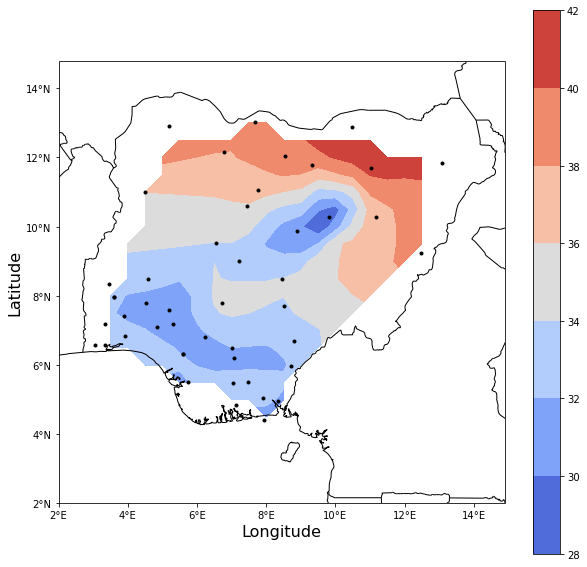

In [103]:

# interpolate
newtmax = griddata((lon,lat), all_stn_wth_files_tmax[11100:11101][stn].squeeze(axis = 0),
                   (lonvals,latvals),method='linear')

# plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

#ax = plt.axes(projection=ccrs.PlateCarree())

dat = ax.contourf(lonvals,latvals,newtmax, cmap='coolwarm')
ax.plot(lon,lat,'k.')
ax.set_global()
ax.coastlines()
ax.set_extent([2, 14.9, 2, 14.8])
ax.add_feature(cfeature.BORDERS)

# Define the xticks for longitude
ax.set_xticks(np.arange(2,15, 2), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
# Define the yticks for latitude
ax.set_yticks(np.arange(2, 15,2), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.colorbar(dat)

# plt.savefig('linear_interpolated.jpg')
#plt.close(fig)